# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model](https://open.spotify.com/track/4R3AU2pjv8ge2siX1fVbZs?si=b2712f32da0e4358) or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [58]:
# Load the libraries as required.
import pandas as pd
import numpy as np
import pickle
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, PowerTransformer, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [6]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [7]:
#Show the dataframe
fires_dt

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


# Get X and Y

Create the features data frame and target data.

In [8]:
#Create the new dataframe, removing column 'area'
x_df = fires_dt.drop (columns=['area'], axis=1)

#Split the data into training and testing sets
y_df = fires_dt['area']
X_train, X_test, Y_train, Y_test = train_test_split(x_df, y_df, test_size = 0.3, random_state = 42)

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [9]:
#Define numerical and categorical columns
num_values = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
categ_values = ['month', 'day']

#Pipline for numerical features
pipe_num_values = Pipeline([
    ('standardizer', RobustScaler())
])

#Pipline for categorical features
pipe_cat_values = Pipeline([
   ('standardizer', OneHotEncoder(handle_unknown='infrequent_if_exist') )
])

#ColumnTransformer
preproc1 = ColumnTransformer([
    ('num', pipe_num_values, num_values),
    ('cat', pipe_cat_values, categ_values)]
    , remainder='drop'
    )

preproc1

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('standardizer',
                                                  RobustScaler())]),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat',
                                 Pipeline(steps=[('standardizer',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'))]),
                                 ['month', 'day'])])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [ ]:
#Use Yeo-Johnson transformation and scaling for numeric features, one-hot encoding for categorical features
preproc2 = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('yeo_johnson', PowerTransformer(method='yeo-johnson')),
            ('scaler', StandardScaler())
        ]), num_values),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categ_values) # Ignore unknown categories
    ]
)

preproc2

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('yeo_johnson',
                                                  PowerTransformer()),
                                                 ('scaler', StandardScaler())]),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['month', 'day'])])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [34]:
#Baseline regressor
baseline_regressor = LinearRegression()

#Advanced regressor
advanced_regressor = RandomForestRegressor(random_state=42)

In [35]:
# Pipeline A = preproc1 + baseline
pipeline_a = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', baseline_regressor)
])
pipeline_a

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardizer',
                                                                   RobustScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat',
                                                  Pipeline(steps=[('standardizer',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist'))]),
                                                  ['month', 'day'])])),
                ('regressor', LinearRegression())])

In [36]:
# Pipeline B = preproc2 + baseline
pipeline_b = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', baseline_regressor)
])
pipeline_b

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('yeo_johnson',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', LinearRegression())])

In [37]:
# Pipeline C = preproc1 + advanced model
pipeline_c = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', advanced_regressor)
])
pipeline_c

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardizer',
                                                                   RobustScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat',
                                                  Pipeline(steps=[('standardizer',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist'))]),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [38]:
# Pipeline D = preproc2 + advanced model
pipeline_d = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', advanced_regressor)
])
pipeline_d 
    

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('yeo_johnson',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [39]:
#Get all the parameters of the pipeline A as a dictionary
pipeline_a.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('standardizer',
                                                     RobustScaler())]),
                                    ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                     'isi', 'temp', 'rh', 'wind', 'rain']),
                                   ('cat',
                                    Pipeline(steps=[('standardizer',
                                                     OneHotEncoder(handle_unknown='infrequent_if_exist'))]),
                                    ['month', 'day'])])),
  ('regressor', LinearRegression())],
 'verbose': False,
 'preprocessing': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('standardizer',
                                                   RobustScaler())]),
                                  ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
     

In [40]:
# Pipeline A = preproc1 + baseline

#Define scoring metric
scoring = ['neg_root_mean_squared_error'] 

#Specify parameters for Linear Regression
param_grid_lr = {
    'regressor__copy_X': [True, False],
    'regressor__fit_intercept': [True, False]
}

#Set up GridSearch
grid_cv_A = GridSearchCV( 
    estimator  = pipeline_a, 
    param_grid = param_grid_lr, 
    scoring    = scoring, 
    cv         = 5,
    refit = "neg_root_mean_squared_error",
    return_train_score=True) 

#Fit the GridSearch on the training data
grid_cv_A.fit(X_train , Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('standardizer',
                                                                                          RobustScaler())]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('standardizer',
                                                                                          OneHotEncoder(handle_unknown='infrequent_if_exist'))]),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', LinearRegression())]),
             param_grid={'regressor__copy_X': [True, False],
                         'regressor__fit_intercept': [True, False]},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['neg_root_mean_squared_error'])

In [41]:
#Create the dataframe with results for the pipline A, sorting
pd.DataFrame(grid_cv_A.cv_results_).sort_values('rank_test_neg_root_mean_squared_error')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__copy_X,param_regressor__fit_intercept,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,...,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_train_neg_root_mean_squared_error,split1_train_neg_root_mean_squared_error,split2_train_neg_root_mean_squared_error,split3_train_neg_root_mean_squared_error,split4_train_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error
0,0.007579,0.002241,0.003637,0.000959,True,True,"{'regressor__copy_X': True, 'regressor__fit_in...",-44.160022,-26.247083,-31.031591,...,-43.966592,24.261029,1,-48.210735,-51.180599,-51.307089,-28.322627,-51.036514,-46.011513,8.919041
2,0.006531,0.000280,0.003559,0.000997,False,True,"{'regressor__copy_X': False, 'regressor__fit_i...",-44.160022,-26.247083,-31.031591,...,-43.966592,24.261029,1,-48.210735,-51.180599,-51.307089,-28.322627,-51.036514,-46.011513,8.919041
1,0.007772,0.001054,0.002913,0.000478,True,False,"{'regressor__copy_X': True, 'regressor__fit_in...",-44.160022,-26.247083,-31.031591,...,-43.967334,24.252766,3,-48.210735,-51.180599,-51.307089,-28.322627,-51.036514,-46.011513,8.919041
3,0.009100,0.001171,0.003265,0.000907,False,False,"{'regressor__copy_X': False, 'regressor__fit_i...",-44.160022,-26.247083,-31.031591,...,-43.967334,24.252766,3,-48.210735,-51.180599,-51.307089,-28.322627,-51.036514,-46.011513,8.919041


In [42]:
#Get all the parameters of the pipeline B as a dictionary
pipeline_b.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('yeo_johnson',
                                                     PowerTransformer()),
                                                    ('scaler', StandardScaler())]),
                                    ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                     'isi', 'temp', 'rh', 'wind', 'rain']),
                                   ('cat', OneHotEncoder(handle_unknown='ignore'),
                                    ['month', 'day'])])),
  ('regressor', LinearRegression())],
 'verbose': False,
 'preprocessing': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('yeo_johnson',
                                                   PowerTransformer()),
                                                  ('scaler', StandardScaler())]),
                                  ['coord_x', 'coord_

In [43]:
# Pipeline B = preproc2 + baseline

#Define scoring metric
scoring = ['neg_root_mean_squared_error']


#Specify parameters for Linear Regression
param_grid_lr = {
    'regressor__copy_X': [True, False],
    'regressor__fit_intercept': [True, False]
}

#Set up GridSearch
grid_cv_B = GridSearchCV( 
    estimator  = pipeline_b, 
    param_grid = param_grid_lr, 
    scoring    = scoring, 
    cv         = 5,
    refit = "neg_root_mean_squared_error",
    return_train_score=True) 

#Fit the GridSearch on the training data
grid_cv_B.fit(X_train , Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('yeo_johnson',
                                                                                          PowerTransformer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', LinearRegression())]),
             param_grid={'regressor__copy_X': [True, False],
                         'regressor__fit_intercept': [True, False]},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['neg_root_mean_squared_error'])

In [44]:
#Create the dataframe with results for the pipline B, sorting
pd.DataFrame(grid_cv_B.cv_results_).sort_values('rank_test_neg_root_mean_squared_error')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__copy_X,param_regressor__fit_intercept,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,...,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_train_neg_root_mean_squared_error,split1_train_neg_root_mean_squared_error,split2_train_neg_root_mean_squared_error,split3_train_neg_root_mean_squared_error,split4_train_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error
1,0.017525,0.001370,0.003610,0.000647,True,False,"{'regressor__copy_X': True, 'regressor__fit_in...",-44.015169,-26.283736,-25.645497,...,-42.835674,24.865539,1,-48.143661,-51.046678,-51.244535,-28.220045,-50.919049,-45.914794,8.92028
3,0.017048,0.000564,0.003543,0.000523,False,False,"{'regressor__copy_X': False, 'regressor__fit_i...",-44.015169,-26.283736,-25.645497,...,-42.835674,24.865539,1,-48.143661,-51.046678,-51.244535,-28.220045,-50.919049,-45.914794,8.92028
0,0.019582,0.002260,0.003736,0.000502,True,True,"{'regressor__copy_X': True, 'regressor__fit_in...",-44.015169,-26.283736,-25.645497,...,-42.838649,24.862908,3,-48.143661,-51.046678,-51.244535,-28.220045,-50.919049,-45.914794,8.92028
2,0.017364,0.000880,0.003752,0.000675,False,True,"{'regressor__copy_X': False, 'regressor__fit_i...",-44.015169,-26.283736,-25.645497,...,-42.838649,24.862908,3,-48.143661,-51.046678,-51.244535,-28.220045,-50.919049,-45.914794,8.92028


In [45]:
#Get all the parameters of the pipeline C as a dictionary
pipeline_c.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('standardizer',
                                                     RobustScaler())]),
                                    ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                     'isi', 'temp', 'rh', 'wind', 'rain']),
                                   ('cat',
                                    Pipeline(steps=[('standardizer',
                                                     OneHotEncoder(handle_unknown='infrequent_if_exist'))]),
                                    ['month', 'day'])])),
  ('regressor', RandomForestRegressor(random_state=42))],
 'verbose': False,
 'preprocessing': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('standardizer',
                                                   RobustScaler())]),
                                  ['coord_x', 'coord_y', 'ffmc'

In [46]:
# Pipeline C = preproc2 + advanced model

#Define scoring metric
scoring = ['neg_log_loss'] 

#Specify parameters for Random Forest
param_grid_rf = {
    'regressor__bootstrap': [True, False],
    'regressor__max_depth': [1, 5, 10, 15],
    'regressor__n_estimators': [100, 200, 300, 400, 500]
}

#Set up GridSearch
grid_cv_C = GridSearchCV(
    estimator=pipeline_c, 
    param_grid=param_grid_rf, 
    cv=5,
    return_train_score=True
)

#Fit the GridSearch on the training data
grid_cv_C.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('standardizer',
                                                                                          RobustScaler())]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('standardizer',
                                                                                          OneHotEncoder(handle_unknown='infrequent_if_exist'))]),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'regressor__bootstrap': [True, False],
                         'regressor__max_depth': [1, 5, 10, 15],
                         'regressor__n_estimators': [100, 200, 300, 400, 500]},
             return_train_score=True)

In [47]:
#Create the dataframe with results for the pipline C, sorting
pd.DataFrame(grid_cv_C.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__bootstrap,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
4,0.402355,0.009295,0.019046,0.000610,True,1,500,"{'regressor__bootstrap': True, 'regressor__max...",-0.166621,-0.041774,...,-0.107127,0.083329,1,0.069953,0.051328,0.065513,0.056456,0.050727,0.058795,0.007694
2,0.245264,0.004065,0.012383,0.000473,True,1,300,"{'regressor__bootstrap': True, 'regressor__max...",-0.153089,-0.047439,...,-0.107165,0.083314,2,0.069849,0.051875,0.066658,0.056897,0.051709,0.059398,0.007535
3,0.317028,0.004152,0.015769,0.000503,True,1,400,"{'regressor__bootstrap': True, 'regressor__max...",-0.155788,-0.048717,...,-0.107225,0.082486,3,0.069037,0.051833,0.065809,0.056792,0.051352,0.058964,0.007236
1,0.179745,0.013099,0.010109,0.000941,True,1,200,"{'regressor__bootstrap': True, 'regressor__max...",-0.161922,-0.053855,...,-0.114607,0.086378,4,0.069128,0.051625,0.067142,0.056364,0.053657,0.059583,0.007170
23,0.304650,0.029994,0.021072,0.003279,False,1,400,"{'regressor__bootstrap': False, 'regressor__ma...",-0.243272,-0.003501,...,-0.122665,0.128918,5,0.054584,0.030693,0.041108,0.032714,0.030530,0.037926,0.009185
24,0.366774,0.007375,0.030268,0.007496,False,1,500,"{'regressor__bootstrap': False, 'regressor__ma...",-0.243272,-0.003501,...,-0.122665,0.128918,6,0.054584,0.030693,0.041108,0.032714,0.030530,0.037926,0.009185
22,0.228576,0.015537,0.017979,0.003769,False,1,300,"{'regressor__bootstrap': False, 'regressor__ma...",-0.243272,-0.003501,...,-0.122665,0.128918,7,0.054584,0.030693,0.041108,0.032714,0.030530,0.037926,0.009185
21,0.144393,0.005669,0.011126,0.001807,False,1,200,"{'regressor__bootstrap': False, 'regressor__ma...",-0.243272,-0.003501,...,-0.122665,0.128918,8,0.054584,0.030693,0.041108,0.032714,0.030530,0.037926,0.009185
20,0.076048,0.003313,0.008508,0.003012,False,1,100,"{'regressor__bootstrap': False, 'regressor__ma...",-0.243272,-0.003501,...,-0.122665,0.128918,9,0.054584,0.030693,0.041108,0.032714,0.030530,0.037926,0.009185
0,0.088339,0.004732,0.007534,0.001673,True,1,100,"{'regressor__bootstrap': True, 'regressor__max...",-0.196181,-0.058677,...,-0.127396,0.101156,10,0.067876,0.052068,0.067332,0.055358,0.051659,0.058858,0.007257


In [48]:
#Get all the parameters of the pipeline D as a dictionary
pipeline_d.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('yeo_johnson',
                                                     PowerTransformer()),
                                                    ('scaler', StandardScaler())]),
                                    ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                     'isi', 'temp', 'rh', 'wind', 'rain']),
                                   ('cat', OneHotEncoder(handle_unknown='ignore'),
                                    ['month', 'day'])])),
  ('regressor', RandomForestRegressor(random_state=42))],
 'verbose': False,
 'preprocessing': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('yeo_johnson',
                                                   PowerTransformer()),
                                                  ('scaler', StandardScaler())]),
                                 

In [49]:
# Pipeline D = preproc2 + advanced model

#Define scoring metric
scoring = ['neg_log_loss'] 

#Specify parameters for Random Forest
param_grid_rf = {
    'regressor__bootstrap': [True, False],
    'regressor__max_depth': [1, 5, 10, 15],
    'regressor__n_estimators': [100, 200, 300, 400, 500]
}

#Set up GridSearch
grid_cv_D = GridSearchCV(
    estimator=pipeline_d, 
    param_grid=param_grid_rf, 
    cv=5,
    return_train_score=True
)

#Fit the GridSearch on the training data
grid_cv_D.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('yeo_johnson',
                                                                                          PowerTransformer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'regressor__bootstrap': [True, False],
                         'regressor__max_depth': [1, 5, 10, 15],
                         'regressor__n_estimators': [100, 200, 300, 400, 500]},
             return_train_score=True)

In [50]:
#Create the dataframe with results for the pipline D, sorting
pd.DataFrame(grid_cv_D.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__bootstrap,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
4,0.406956,0.001345,0.020423,0.001362,True,1,500,"{'regressor__bootstrap': True, 'regressor__max...",-0.152628,-0.041654,...,-0.104297,0.081505,1,0.069954,0.051335,0.065510,0.056456,0.050900,0.058831,0.007656
2,0.258528,0.007000,0.014217,0.001193,True,1,300,"{'regressor__bootstrap': True, 'regressor__max...",-0.139674,-0.047234,...,-0.104441,0.082026,2,0.069849,0.051889,0.066658,0.056897,0.051918,0.059442,0.007490
3,0.332952,0.004871,0.016612,0.001162,True,1,400,"{'regressor__bootstrap': True, 'regressor__max...",-0.142334,-0.048566,...,-0.104504,0.081085,3,0.069039,0.051842,0.065807,0.056792,0.051561,0.059008,0.007191
1,0.177442,0.004592,0.011192,0.000817,True,1,200,"{'regressor__bootstrap': True, 'regressor__max...",-0.146892,-0.053607,...,-0.111551,0.084962,4,0.069128,0.051646,0.067142,0.056364,0.053776,0.059611,0.007146
23,0.305434,0.017469,0.020980,0.005449,False,1,400,"{'regressor__bootstrap': False, 'regressor__ma...",-0.215331,-0.003501,...,-0.117077,0.124084,5,0.054584,0.030693,0.041108,0.032714,0.030530,0.037926,0.009185
24,0.391168,0.023773,0.025345,0.005676,False,1,500,"{'regressor__bootstrap': False, 'regressor__ma...",-0.215331,-0.003501,...,-0.117077,0.124084,6,0.054584,0.030693,0.041108,0.032714,0.030530,0.037926,0.009185
22,0.238092,0.021811,0.014060,0.000660,False,1,300,"{'regressor__bootstrap': False, 'regressor__ma...",-0.215331,-0.003501,...,-0.117077,0.124084,7,0.054584,0.030693,0.041108,0.032714,0.030530,0.037926,0.009185
21,0.154799,0.012216,0.010544,0.000466,False,1,200,"{'regressor__bootstrap': False, 'regressor__ma...",-0.215331,-0.003501,...,-0.117077,0.124084,8,0.054584,0.030693,0.041108,0.032714,0.030530,0.037926,0.009185
20,0.091266,0.008472,0.009208,0.003453,False,1,100,"{'regressor__bootstrap': False, 'regressor__ma...",-0.215331,-0.003501,...,-0.117077,0.124084,9,0.054584,0.030693,0.041108,0.032714,0.030530,0.037926,0.009185
0,0.098153,0.005262,0.007146,0.000890,True,1,100,"{'regressor__bootstrap': True, 'regressor__max...",-0.178271,-0.058413,...,-0.123761,0.098985,10,0.067876,0.052107,0.067332,0.055358,0.051836,0.058902,0.007215


# Evaluate

+ Which model has the best performance?

Analysis:
Pipeline A: preproc1 + LinearRegression
Mean Train Neg RMSE: -46.011513

A value of -46.01 suggests that the model has a relatively high prediction error. The negative RMSE measures how well the model predicts the target variable. The more negative the value, the worse the model's performance. 

Pipeline B: preproc2 + LinearRegression
Mean Train Neg RMSE: -45.914794

This pipeline uses a more complex preprocessing pipeline (preproc2) with transformations such as Yeo-Johnson and scaling, which can improve the model's ability to handle skewed data. Despite the more advanced preprocessing, the negative RMSE of -45.91 is slightly better than Pipeline A (which had -46.01), but the difference is marginal. It suggests that linear regression is still struggling to capture the complexity in the data, even with more advanced preprocessing.

Pipeline A vs. B: The improved preprocessing in Pipeline B (using Yeo-Johnson transformation and scaling) slightly improved the model's performance, but the impact was marginal.

Pipeline C: preproc1 + RandomForestRegressor
Mean Train Score: 0.058795

A score of 0.058795 indicates that the model explains very little of the variance in the target data (closer to 0 means poor model fit).

Pipeline D: preproc2 + RandomForestRegressor
Mean Train Score: 0.058831

The score of 0.058831 is almost identical to Pipeline C's 0.058795. The difference in preprocessing techniques (Yeo-Johnson transformation and scaling) doesn't seem to significantly affect the performance of the Random Forest model, based on the R² score.

Pipeline C vs. D: The use of different preprocessing in Pipeline C and Pipeline D (preproc1 vs. preproc2) didn't make a noticeable difference in train score, suggesting that Random Forest may not benefit from these transformations as expected.

Conclusion:
Linear Regression Models (Pipeline A and B) appear to have relatively high negative RMSE values (~ -46), which indicates poor predictive performance. The difference between Pipeline A and Pipeline B is minimal, meaning the additional preprocessing in Pipeline B (Yeo-Johnson transformation) didn't significantly improve performance. Random Forest Regressor Models (Pipeline C and D) have a train score of around 0.0588, which is very low and indicates that the model doesn't explain much of the variance in the target variable. 

Model Choice: 

Both Linear Regression and Random Forest seem to be underperforming in this case. However, we need to choose one; let's take Pipeline D because it uses more advanced preprocessing (preproc2) with Yeo-Johnson transformation and scaling, the preprocessing might help the model better handle non-normal distributions and skewed features. Although the train score is still low, Random Forest will likely perform better than Linear Regression if further improvements can be made.

# Export

+ Save the best performing model to a pickle file.

In [52]:
# Save the best performing model

with open('./random_forest_best_model.pkl', 'wb') as file:
    pickle.dump(grid_cv_D.best_estimator_, file)

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

<Figure size 1000x600 with 0 Axes>

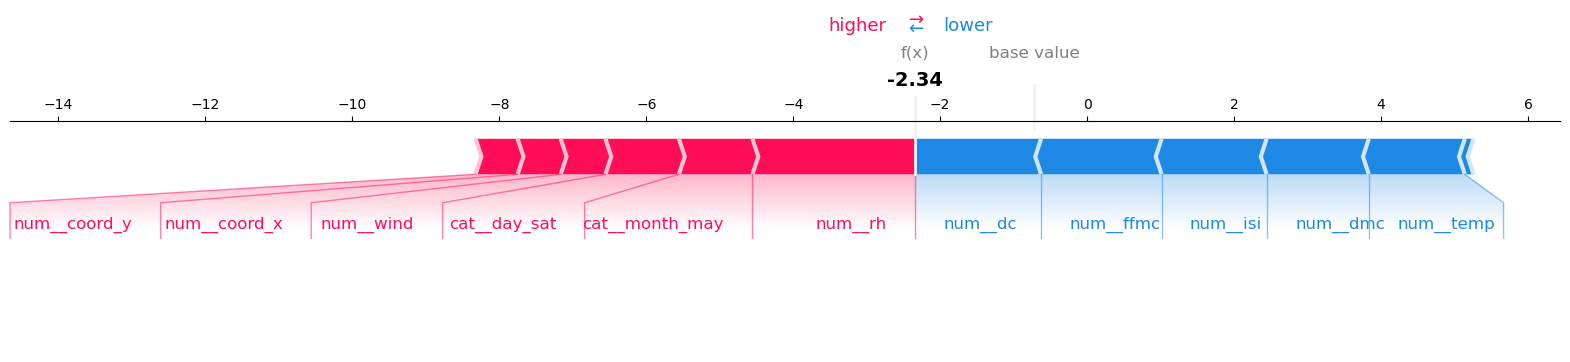

In [81]:
#Fit the pipeline on the training data
pipeline_d.fit(X_train, Y_train)

# Transform the test data using the preprocessing step
data_transform = pipeline_d.named_steps['preprocessing'].transform(X_test)

# Use SHAP TreeExplainer for the RandomForestRegressor
explainer = shap.TreeExplainer(pipeline_d.named_steps['regressor'])

# Compute SHAP values for the transformed test data
shap_values = explainer.shap_values(data_transform)

# Plot the SHAP values for a specific instance, for example, the first observation in the test set
shap.initjs()
plt.figure(figsize=(10, 6))
shap.force_plot(shap_values[0][0], data_transform[0], feature_names=pipeline_d.named_steps['preprocessing'].get_feature_names_out(),matplotlib=True)

1. Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction:

The observation has a prediction value of -2.34:
- the features on the left side (in red) contribute positively to the prediction, pushing it in the positive direction (toward a higher value). Examples of these features include:
num__coord_y, num__coord_x, num__wind, which all push the prediction toward a higher value.
- the features on the right side (in blue) contribute negatively, pulling the prediction lower. For example, num__dmc, num__isi, and num__temp decrease the prediction value.

2. In general, across the complete training set, which features are the most and least important:

Most Important Features: These features have the highest mean absolute SHAP values (located farthest from the base value in either the red or blue sections), indicating that they most impact the model's predictions.
- num__coord_x and num__coord_y: If these are geographical features, they may have a strong influence on predicting certain outcomes 
- num__wind: Environmental conditions like wind speed are likely impactful
- num__dmc, num__isi, num__temp: environmental conditions that influence fire behavior

Least important features: Features that have small contributions (close to the base value in the center) are less influential. 
- num_rh and num_dc have a minimal impact on the prediction.


3. If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

The removing features should have minimal contributions to the prediction, in the case of num_dc and num__rh
Testing feature removal: 
- remove the least impactful features from the model;
- evaluate the model performance using metrics and compare the results before and after removing these features.
If the model's performance remains stable or improves after removing these features, it suggests that they were not adding significant value to the model.


## Criteria

The [rubric](./assignment_3_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.